In [2]:
# Cell 1: Import libraries and set random seeds for reproducibility
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries imported and seeds set!")


✅ Libraries imported and seeds set!


In [3]:
# Cell 2: Load dataset metadata and split data into training and validation sets
# Adjust 'dataset_path' as needed for your environment.
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Read CSV files
labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

# Merge metadata on 'patientId' and map targets: 0 = Normal, 1 = Pneumonia
merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

# Split into 80% training and 20% validation with stratification
train_df, val_df = train_test_split(labels_simple, test_size=0.2, random_state=SEED, stratify=labels_simple['Target'])
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 21347
Validation samples: 5337


In [4]:
# Cell 3: Define a function to load and preprocess DICOM images
# This function reads a DICOM file, normalizes pixel values, resizes the image to (299,299),
# and converts a grayscale image to 3-channel RGB (required by Xception).
def load_preprocess_dicom(dicom_path, img_size=(299, 299)):
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize pixel values to [0, 1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize image to desired dimensions
    img_resized = cv2.resize(img_norm, img_size)
    # Convert grayscale to RGB by stacking the single channel three times
    img_rgb = np.stack([img_resized]*3, axis=-1)
    return img_rgb

# Test the function on a sample image
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", train_df.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image shape (should be 299x299x3):", sample_img.shape)


✅ Sample image shape (should be 299x299x3): (299, 299, 3)


In [5]:
# Cell 4: Create data generators for training and validation
# This cell creates an infinite data generator for training (to avoid running out of data)
# and a finite generator for validation.
def data_generator(df, batch_size=64, img_size=(299, 299), infinite=True):
    def gen():
        if infinite:
            while True:
                # Shuffle the DataFrame at the start of each epoch
                shuffled_df = df.sample(frac=1).reset_index(drop=True)
                for _, row in shuffled_df.iterrows():
                    patient_id = row['patientId']
                    label = 1 if row['Target'] == 'Pneumonia' else 0
                    dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                    img = load_preprocess_dicom(dicom_path, img_size)
                    yield img, label
        else:
            for _, row in df.iterrows():
                patient_id = row['patientId']
                label = 1 if row['Target'] == 'Pneumonia' else 0
                dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                img = load_preprocess_dicom(dicom_path, img_size)
                yield img, label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 3), ())
    )
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 64
train_ds = data_generator(train_df, batch_size=BATCH_SIZE, img_size=(299,299), infinite=True)
val_ds = data_generator(val_df, batch_size=BATCH_SIZE, img_size=(299,299), infinite=False)
print("✅ Data generators created with batch size:", BATCH_SIZE)
# Cell 5: Build the Xception model with frozen base layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# Load the Xception base model with ImageNet weights, excluding the top classifier layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze the base model layers
base_model.trainable = False

# Build the complete model by adding a global average pooling layer and a custom classifier head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with an initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


✅ Data generators created with batch size: 64
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123,881 (80.58 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [6]:
# Cell 5: Build the Xception model with frozen base layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# Load the Xception base model with ImageNet weights, excluding the top classifier layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze the base model layers
base_model.trainable = False

# Build the complete model by adding a global average pooling layer and a custom classifier head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with an initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123,881 (80.58 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [7]:
# Cell 6: Compute class weights to mitigate class imbalance
y_train = train_df['Target'].apply(lambda x: 1 if x == 'Pneumonia' else 0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}
print("✅ Class weights computed:", class_weights)


✅ Class weights computed: {0: 0.6454314567333858, 1: 2.219022869022869}


In [8]:
# Cell 7: Define callbacks for training
# We use EarlyStopping and ReduceLROnPlateau to monitor validation loss and adjust the learning rate.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("✅ Callbacks defined.")


✅ Callbacks defined.


In [9]:
# Cell 8: Train the Xception model with the frozen base (initial training of the classifier head)
steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch)

EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,  # One epoch = one full pass over training data
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Steps per epoch: 334
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7077 - loss: 0.5717

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


334/334 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.7078 - loss: 0.5717 - val_accuracy: 0.7444 - val_loss: 0.5045 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7326 - loss: 0.5339 - val_accuracy: 0.6968 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7290 - loss: 0.5261 - val_accuracy: 0.7444 - val_loss: 0.5008 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7416 - loss: 0.5075 - val_accuracy: 0.7008 - val_loss: 0.5732 - learning_rate: 0.0010
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 327s 983ms/step - accuracy: 0.7401 - loss: 0.5103 - val_accuracy: 0.7834 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 287s 861ms/step - accuracy: 0.7470 - loss: 0.5019 - val_accuracy: 0.6987 - val_loss: 0.5649 - learning_rate: 0.0010
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 287s 860ms/step - accuracy: 0.7406 - loss: 0.49

In [10]:
# Cell 9: Clone the frozen-base model to preserve its weights for later comparison
model_frozen = tf.keras.models.clone_model(model)
model_frozen.build((None, 299, 299, 3))
model_frozen.set_weights(model.get_weights())
print("✅ Frozen-base model cloned.")


✅ Frozen-base model cloned.


In [11]:
# Cell 10: Unfreeze the Xception base layers for fine-tuning (Stage 2)
# You can choose to unfreeze all layers or only part of the base. Here, we unfreeze all.
base_model.trainable = True

# Optionally, to partially unfreeze, uncomment the following and adjust the index:
# fine_tune_at = 100  # for example, unfreeze only the last 100 layers
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
# for layer in base_model.layers[fine_tune_at:]:
#     layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("✅ Base model layers unfrozen for fine-tuning.")


✅ Base model layers unfrozen for fine-tuning.


In [12]:
# Cell 11: Fine-tune the model with unfrozen base layers
FINE_TUNE_EPOCHS = 10  # Adjust based on your observations

fine_tune_history = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.7184 - loss: 0.5588 - val_accuracy: 0.7613 - val_loss: 0.4796 - learning_rate: 1.0000e-05
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.7743 - loss: 0.4437 - val_accuracy: 0.7825 - val_loss: 0.4442 - learning_rate: 1.0000e-05
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.8172 - loss: 0.3698 - val_accuracy: 0.7965 - val_loss: 0.4416 - learning_rate: 1.0000e-05
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.8760 - loss: 0.2744 - val_accuracy: 0.8014 - val_loss: 0.4605 - learning_rate: 1.0000e-05
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.9311 - loss: 0.1750 - val_accuracy: 0.8132 - val_loss: 0.5054 - learning_rate: 1.0000e-05
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.9725 - loss: 0.0917
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
334/334 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accurac

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

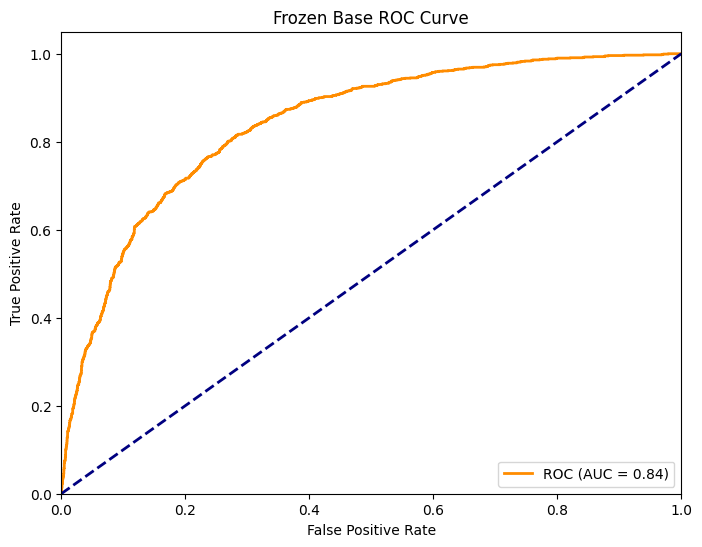

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

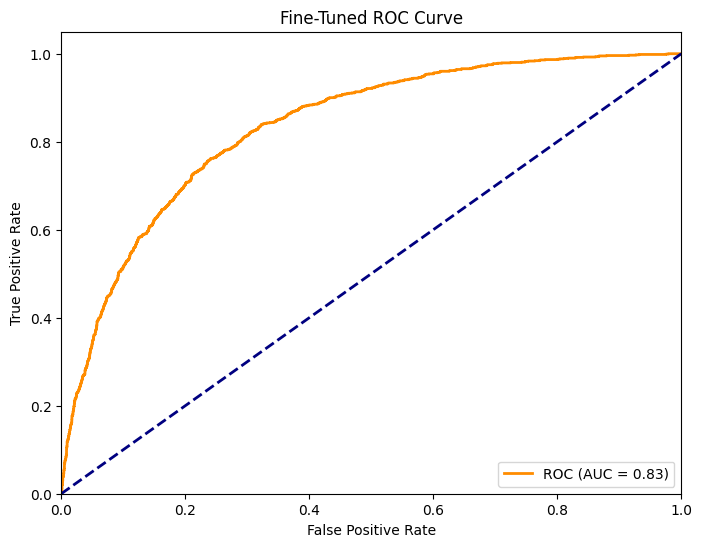

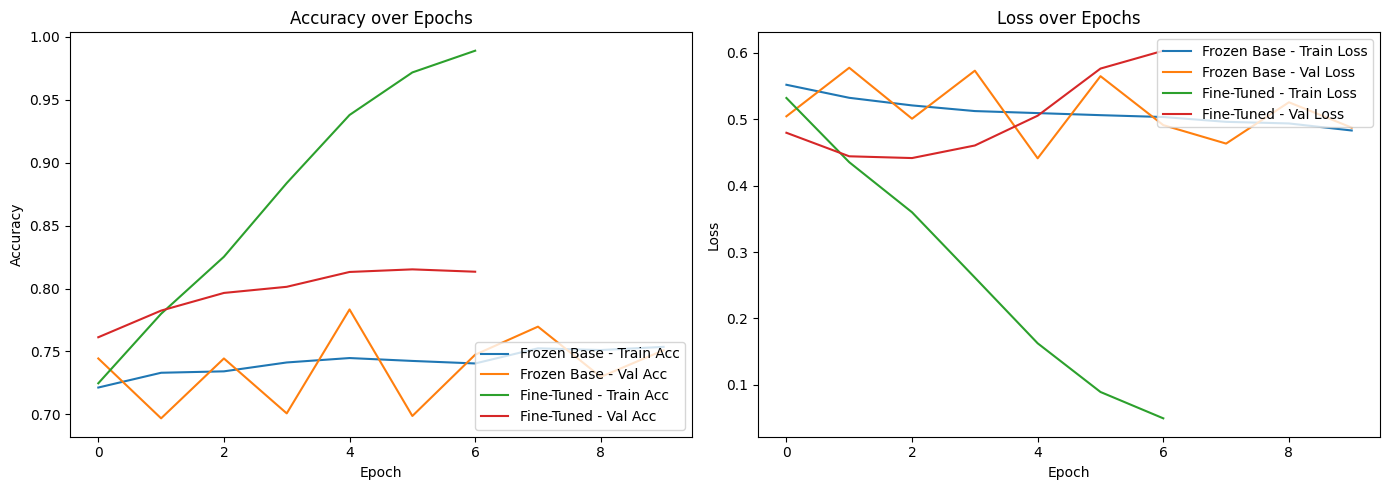

In [13]:
# Cell 12: Evaluate the models and plot learning curves
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def evaluate_model(model, dataset, stage_name=""):
    y_true = []
    y_pred = []
    y_scores = []
    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())
        y_scores.extend(preds.flatten())
        
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    print(f"=== {stage_name} Model ===")
    print("Accuracy: {:.2f}%".format(acc * 100))
    print("Precision: {:.2f}".format(prec))
    print("Recall (Sensitivity): {:.2f}".format(rec))
    print("F1-Score: {:.2f}".format(f1))
    print("Confusion Matrix:\n", cm)
    print("AUC: {:.2f}".format(roc_auc))
    print()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{stage_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the frozen-base model
evaluate_model(model_frozen, val_ds, stage_name="Frozen Base")

# Evaluate the fine-tuned model (current model)
evaluate_model(model, val_ds, stage_name="Fine-Tuned")

# Plot combined learning curves (accuracy and loss)
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Frozen Base - Train Acc')
plt.plot(history.history['val_accuracy'], label='Frozen Base - Val Acc')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-Tuned - Train Acc')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-Tuned - Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Frozen Base - Train Loss')
plt.plot(history.history['val_loss'], label='Frozen Base - Val Loss')
plt.plot(fine_tune_history.history['loss'], label='Fine-Tuned - Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-Tuned - Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
